In [395]:
library(tidyverse)
library(lubridate)
library(modelr)
theme_set(theme_minimal())

# Lecture 23: 
In this lecture we will analyze data generated during the course of this semester by you, the students of STATS 306. The particular questions I am interested in are:
- How many students used [jupyter.stats306.org](https://jupyter.stats306.org) over the course of the semester, and for what reasons?
- How does usage of this website correlate with student performance in the class?
- Should we continue offering this service in the future?

Note: for privacy reasons discussed below, some of the data needed to run this notebook are not distributed. You will not be able to do "Run All" on this notebook without encountering errors.

We are going to be analyzing some student level data. To protect the names of the innocent, I have replaced all uniqnames with that of a randomly chosen [Simpsons character](http://www.simpsoncrazy.com/characters/poster).
![simpsons cast](http://www.simpsoncrazy.com/content/news/new-simpsons-poster-large.jpg)

In [396]:
library(XML)
library(snakecase)
# quickly scrape all simpsons characters
doc = htmlParse("http://www.simpsoncrazy.com/characters/poster")
simps = xpathSApply(doc, "//div[@class='intro']/ul/li/@id") %>% setNames(NULL) %>% to_snake_case %>% unique
head(simps)
length(simps)

[1] "michael_knight"           "gerald"                  
[3] "ralph_wiggum"             "burns_goon"              
[5] "springfield_gorge_ranger" "antoine_tex_ohara"       

[1] 318

The next slide analyzes raw grade data from the class. For privacy reasons I will not distribute this file, even in anonymized form. 

In [397]:
#grades = read_csv("~/Downloads/2018-04-09T1555_Grades-STATS_306_001_WN_2018.csv", 
#         skip = 3, col_names = F, na = c("", "NA", "EX"))
#grades = grades %>% select(user=X4, X8:X15, X18)
#names(grades)[2:length(grades)] = c(str_c("ps", 1:8), "mt1")
#users = distinct(grades, user)
#anon = simps[sample(nrow(users), replace = F)]
#users = users %>% mutate(anon_user = anon)
#grades = grades %>% left_join(users) %>% mutate(user = anon_user) %>% 
#         select(-anon_user)
#grades = grades %>% map(~ ifelse(is.na(.), 0, .)) %>% as.tibble %>% 
#    gather(assignment, grade, -user) %>% 
#    mutate(gpct = ifelse(assignment == "mt1", grade / 45, grade / 20),
#           w = ifelse(assignment == "mt1", .5, .5 / 8)) %>% print
#save(grades, file = "grades.RData")
load("grades.RData")

The next slide analyzes log files from the Google cloud service used to host the web site. I have already done
some preprocessing on these data sets to make them more easily importable into R. Although these data are less sensitive than the grade data, I have decided for privacy reasons not to post them either.

In [398]:
#logins <- read_csv('logins.csv.gz') %>% select(-1)
#anon_logins = left_join(logins, users) %>% 
#    mutate(admin = user %in% c('jonth', 'bwjang', 'kasfaw', 'lpuglisi'),
#           duration = (stop_time - start_time),
#           user = ifelse(admin, user, anon_user)) %>% 
#    filter(!is.na(user)) %>% mutate(duration_h = as.numeric(duration / 3600))  %>% 
#    select(-anon_user)
#save(anon_logins, file="anon_logins.RData")

In [399]:
load("anon_logins.RData")
print(anon_logins, width = Inf)

# A tibble: 1,860 x 8
   exit_code reason    start_time          stop_time          
       <int> <chr>     <dttm>              <dttm>             
 1         0 Completed 2018-04-09 15:20:14 2018-04-09 16:27:14
 2         0 Completed 2018-04-09 14:44:41 2018-04-09 15:57:14
 3         0 Completed 2018-04-09 14:17:26 2018-04-09 15:37:14
 4         0 <NA>      2018-04-09 14:05:05 2018-04-09 15:07:14
 5         0 <NA>      2018-04-09 13:39:33 2018-04-09 14:47:14
 6         0 <NA>      2018-04-09 13:24:22 2018-04-09 14:37:14
 7         0 <NA>      2018-04-09 14:20:41 2018-04-09 14:25:40
 8         0 <NA>      2018-04-09 14:20:36 2018-04-09 14:25:36
 9         0 <NA>      2018-04-09 14:16:25 2018-04-09 14:21:25
10         0 <NA>      2018-04-09 14:16:18 2018-04-09 14:21:18
   user                        admin duration duration_h
   <chr>                       <lgl> <time>        <dbl>
 1 chester_lampwick            F     4020         1.12  
 2 mayor_diamond_joe_quimby    F     4353         1

Users have logged in to the site a total of 1,860 times since it went online in January. Here is a histogram of the number of hours spent on the site per session:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


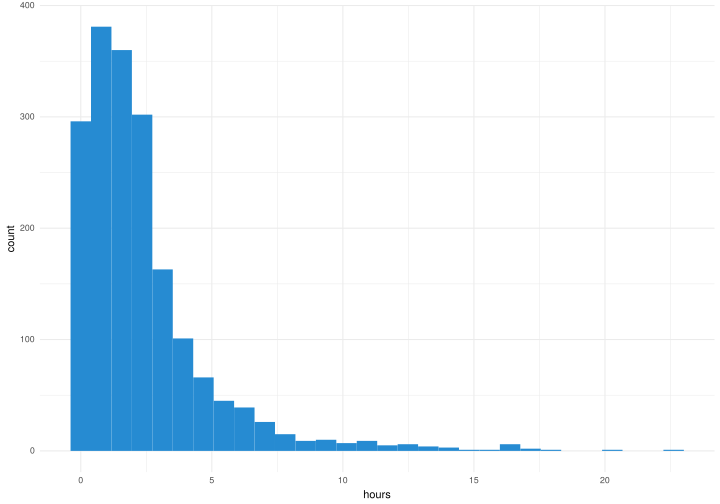

In [400]:
ggplot(anon_logins, aes(x = duration_h)) + geom_histogram() + xlab("hours")

And per-user:

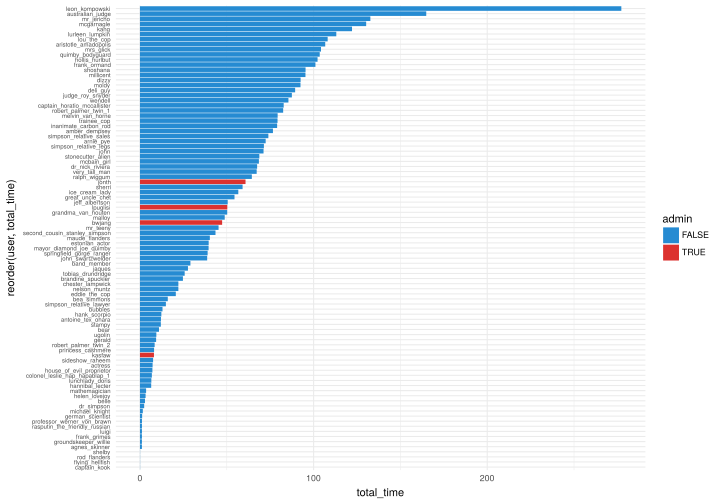

In [401]:
anon_logins %>% group_by(user, admin) %>% summarize(total_time = sum(duration_h)) %>% 
    ggplot(aes(x = reorder(user, total_time), y = total_time, fill = admin)) + geom_col() + coord_flip() +
    theme_minimal() + theme(axis.text.y = element_text(size=6))

One thing I have noticed is that certain students appear to go to bed much later than their professors: :)

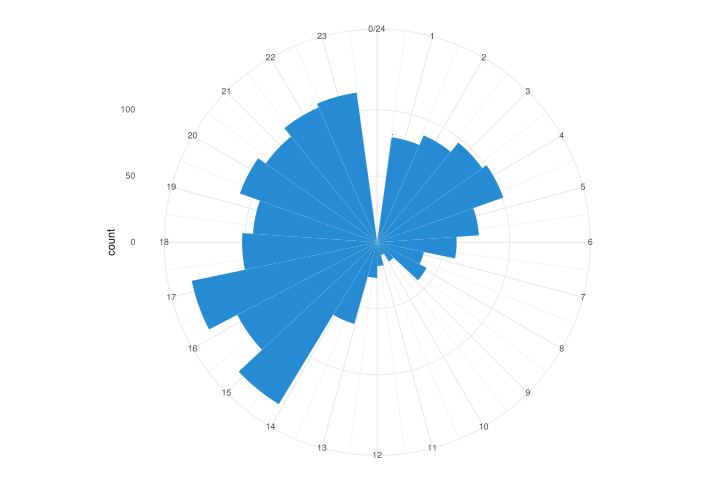

In [402]:
anon_logins %>% mutate(stop_hour = hour(stop_time)) %>%  
    ggplot(aes(x = stop_hour)) + geom_histogram(bins = 24) + coord_polar(start = 0) +
    scale_x_continuous("", limits = c(0, 24), breaks = seq(0, 24), labels = seq(0, 
        24)) + theme_minimal()

Which days of the week are most active?

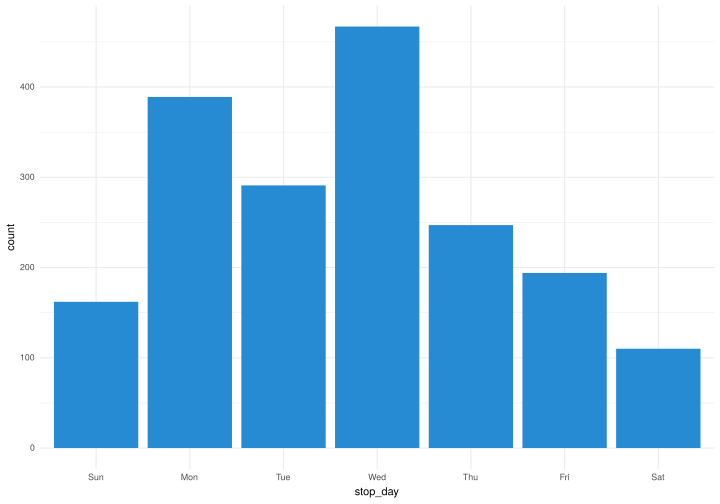

In [403]:
anon_logins %>% mutate(stop_day = wday(stop_time, label = T)) %>%  
    ggplot(aes(x = stop_day)) + geom_bar()

Next we will summarize the activity on a daily basis:

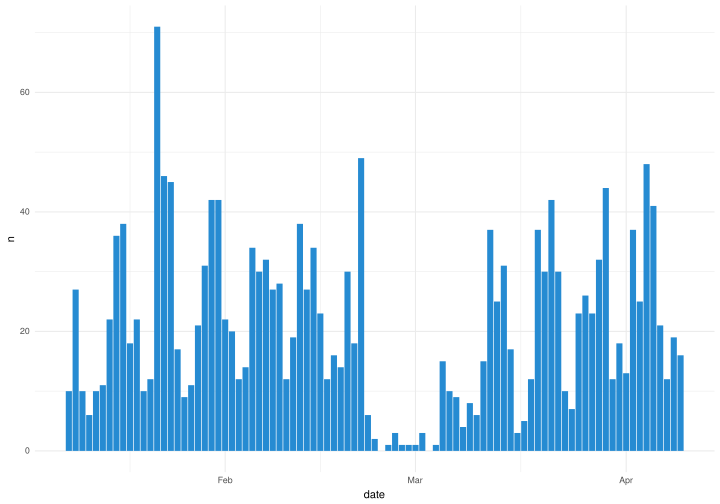

In [404]:
p = anon_logins %>% mutate(date = date(start_time)) %>% count(date) %>%
    ggplot(aes(x = date, y = n)) + geom_col()
p

The spikes are generally due to homework due dates, or the midterm. The big dip in late February/early March is of course due to winter break!

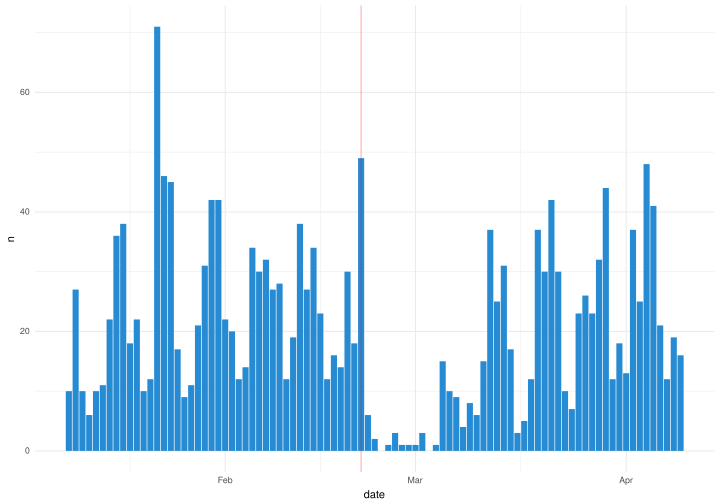

In [405]:
p = p + geom_vline(xintercept = make_date(2018, 02, 21), color="red", alpha = 1/3)
p

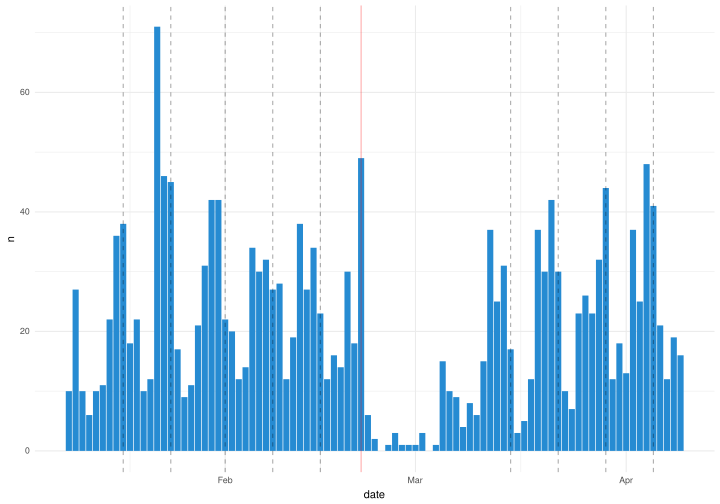

In [406]:
hw_due_dates = make_date(2018, c(1, 1, 2, 2, 2, 3, 3, 3, 4), 
                               c(17, 24, 1, 8, 15, 15, 22, 29, 5))
p + geom_vline(xintercept = hw_due_dates, color = "black", alpha = 1/3, linetype = "dashed")

When do your friendly teaching staff (who do not get to be anonymous!) tend to log in?

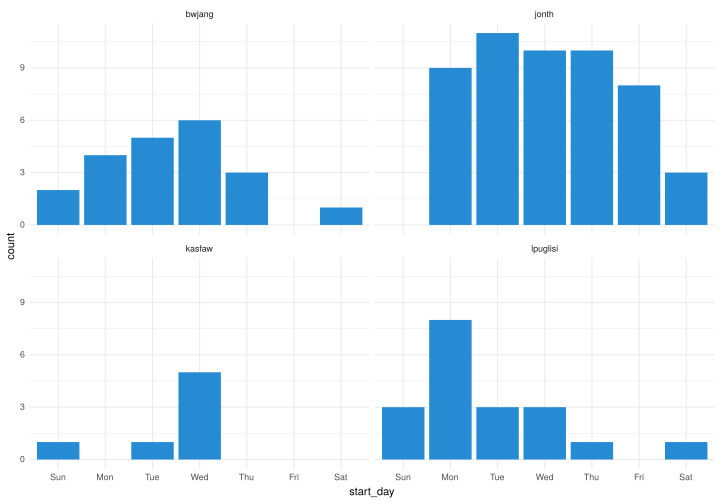

In [407]:
anon_logins %>% filter(admin) %>% 
    mutate(start_day = wday(stop_time, label = T)) %>%  
    ggplot(aes(x = start_day)) + geom_bar() + facet_wrap(~ user)

Note that it is possible to classify PhD students vs. professors with 100% accuracy based on whether they log in on Friday ;-)

Another interesting question is how many concurrent logins are there at any given time?

In [408]:
anon_ts = anon_logins %>% gather(event_type, time, ends_with("_time")) %>% arrange(time) %>% 
                          mutate(duser = ifelse(event_type == "start_time", 1L, -1L)) %>% 
                          mutate(total_users = cumsum(duser)) %>% print

# A tibble: 3,720 x 10
   exit_… reason user  admin dura… durat… even… time                duser tota…
    <int> <chr>  <chr> <lgl> <tim>  <dbl> <chr> <dttm>              <int> <int>
 1      0 <NA>   jonth T     300   0.0833 star… 2018-01-09 15:56:58     1     1
 2      0 <NA>   jonth T     300   0.0833 stop… 2018-01-09 16:01:58    -1     0
 3      0 Compl… jonth T     1189  0.330  star… 2018-01-09 16:02:02     1     1
 4      0 Compl… jonth T     1189  0.330  stop… 2018-01-09 16:21:51    -1     0
 5      0 Compl… jonth T     1779  0.494  star… 2018-01-09 18:12:11     1     1
 6      0 Compl… jonth T     1779  0.494  stop… 2018-01-09 18:41:50    -1     0
 7      0 <NA>   moldy F     300   0.0833 star… 2018-01-09 18:42:05     1     1
 8      0 <NA>   rod_… F     300   0.0833 star… 2018-01-09 18:42:07     1     2
 9      0 <NA>   jonth T     300   0.0833 star… 2018-01-09 18:42:53     1     3
10      0 <NA>   moldy F     300   0.0833 stop… 2018-01-09 18:47:05    -1     2
# ... with 3,710 

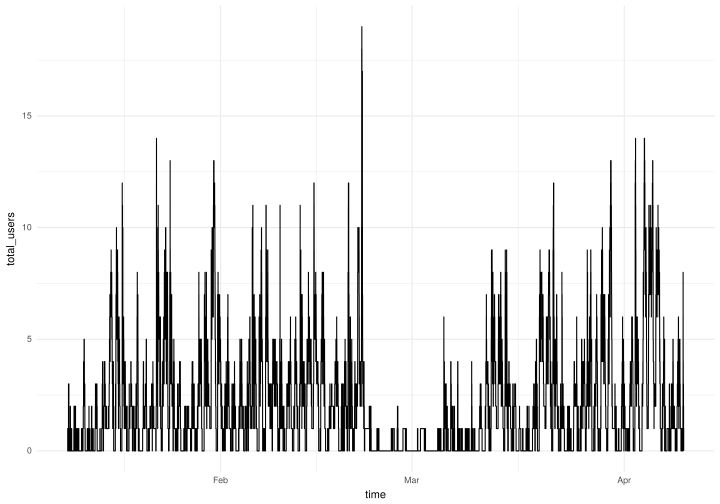

In [409]:
ggplot(anon_ts, aes(x = time, y = total_users)) + geom_step()


This is hard to see to to will look at the maximum # of logins on any given day:

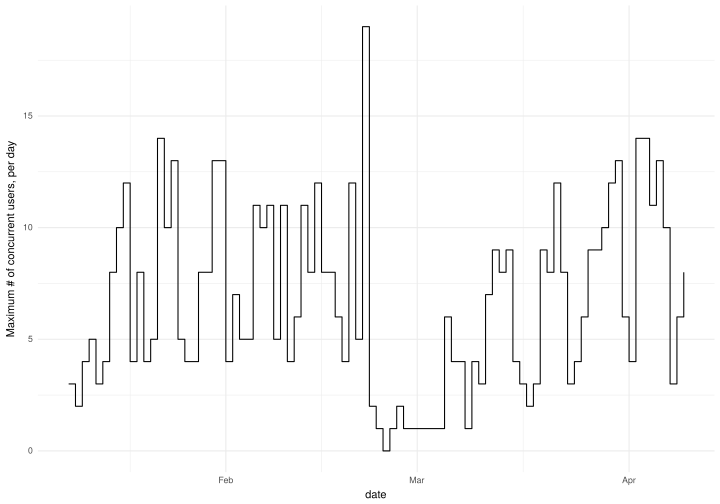

In [410]:
anon_ts %>% mutate(date = as_date(time)) %>% group_by(date) %>% summarize(m = max(total_users)) %>% 
    ggplot(aes(date, m)) + geom_step() + ylab("Maximum # of concurrent users, per day")

## Grades

In [411]:
grades %>% group_by(assignment) %>% summarize(z = sum(grade == 0), m = mean(grade))

  assignment z m       
1 mt1        1 30.95905
2 ps1        9 17.75000
3 ps2        5 16.76724
4 ps3        3 18.24138
5 ps4        1 18.59483
6 ps5        6 16.77586
7 ps6        2 17.61638
8 ps7        3 17.96552
9 ps8        9 17.03017

What was the relative level of difficulty of each problem set? To figure this out we will use regression. We imagine that each student $i$ has a certain level of ability $\alpha_i$, and each problem set $j$ has a certain level of difficulty $\beta_j$. Our model is:

$$
\text{score}_{ij} = \alpha_i + \beta_j.
$$

In [412]:
library(lme4)
mod = lmer(grade ~ assignment + (1|user), data = filter(grades, assignment != "mt1"))

In [413]:
summary(mod)

Linear mixed model fit by REML ['lmerMod']
Formula: grade ~ assignment + (1 | user)
   Data: filter(grades, assignment != "mt1")

REML criterion at convergence: 5176.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7973 -0.1154  0.1623  0.4603  2.8110 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept)  5.31    2.304   
 Residual             13.02    3.608   
Number of obs: 928, groups:  user, 116

Fixed effects:
              Estimate Std. Error t value
(Intercept)    17.7500     0.3975   44.65
assignmentps2  -0.9828     0.4738   -2.07
assignmentps3   0.4914     0.4738    1.04
assignmentps4   0.8448     0.4738    1.78
assignmentps5  -0.9741     0.4738   -2.06
assignmentps6  -0.1336     0.4738   -0.28
assignmentps7   0.2155     0.4738    0.45
assignmentps8  -0.7198     0.4738   -1.52

Correlation of Fixed Effects:
            (Intr) assgn2 assgn3 assgn4 assgn5 assgn6 assgn7
assgnmntps2 -0.596                                          
assgnmn

This model has a problem in that we are not handling zero values correctly. Does a zero on the problem set indicate that it was so difficult that students couldn't get *any* points? No, it means they did not attempt it at all (or for some other reason did not hand it in.) We will condition on the score being non-zero:

In [414]:
mod = lmer(grade ~ assignment + (1|user), 
           data = filter(grades, assignment != "mt1", grade > 0))
summary(mod)

Linear mixed model fit by REML ['lmerMod']
Formula: grade ~ assignment + (1 | user)
   Data: filter(grades, assignment != "mt1", grade > 0)

REML criterion at convergence: 3922.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7467 -0.2628  0.1668  0.5372  2.9943 

Random effects:
 Groups   Name        Variance Std.Dev.
 user     (Intercept) 1.358    1.165   
 Residual             4.062    2.015   
Number of obs: 890, groups:  user, 115

Fixed effects:
              Estimate Std. Error t value
(Intercept)    19.2139     0.2237   85.89
assignmentps2  -1.7652     0.2735   -6.45
assignmentps3  -0.5039     0.2725   -1.85
assignmentps4  -0.4574     0.2712   -1.69
assignmentps5  -1.5191     0.2745   -5.53
assignmentps6  -1.3072     0.2719   -4.81
assignmentps7  -0.8097     0.2725   -2.97
assignmentps8  -0.8182     0.2765   -2.96

Correlation of Fixed Effects:
            (Intr) assgn2 assgn3 assgn4 assgn5 assgn6 assgn7
assgnmntps2 -0.624                                       

Based on the regression it seems like problem sets 2, 5 and 6 were the hardest. Thoughts?

How much does homework difficulty correlate with user logins?

In [415]:
difficulty = tibble(
    pset = str_c("ps", 1:8), 
    difficulty = -(summary(mod) %>% coef %>% .[, "Estimate"]),
    week = c(2:6, 10:12)
    ) %>% print
difficulty[[1, 2]] = 0

# A tibble: 8 x 3
  pset  difficulty  week
  <chr>      <dbl> <int>
1 ps1      -19.2       2
2 ps2        1.77      3
3 ps3        0.504     4
4 ps4        0.457     5
5 ps5        1.52      6
6 ps6        1.31     10
7 ps7        0.810    11
8 ps8        0.818    12


In [416]:
logins_grades = anon_logins %>% mutate(week = as.integer(week(start_time))) %>% 
    group_by(week) %>% 
    summarize(s = sum(duration)) %>% 
    inner_join(difficulty) %>% print()

Joining, by = "week"


# A tibble: 8 x 4
   week s       pset  difficulty
  <int> <time>  <chr>      <dbl>
1     2 306979  ps1        0    
2     3 1317923 ps2        1.77 
3     4 1504862 ps3        0.504
4     5 1580570 ps4        0.457
5     6 1622096 ps5        1.52 
6    10 418431  ps6        1.31 
7    11 1131283 ps7        0.810
8    12 1518819 ps8        0.818


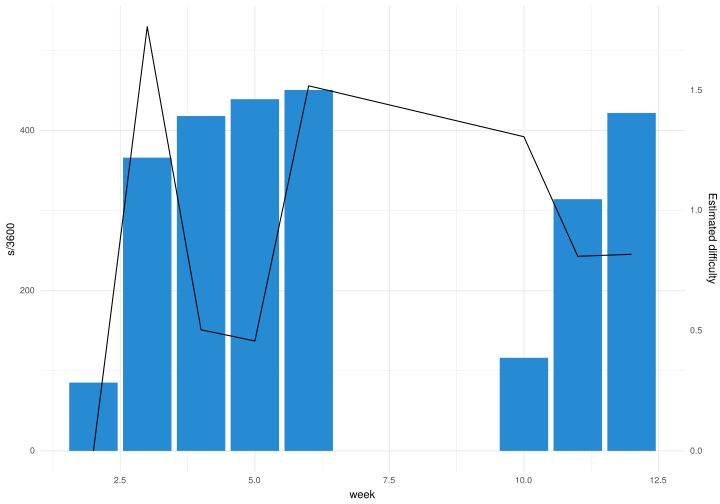

In [417]:
logins_grades  %>% 
    ggplot(aes(week)) + geom_col(aes(y = s / 3600)) + 
    geom_path(aes(y = 300 * difficulty), colour = "black") +
    scale_y_continuous(sec.axis = sec_axis(~ . / 300, name = "Estimated difficulty"))

Finally I was curious about how time spent on the web site correlated with overall student performance. Does more time lead to higher or lower scores on average?

In [418]:
avg_grades = grades %>% group_by(user) %>%
    arrange(user, desc(assignment), grade) %>% mutate(k = row_number()) %>% print %>% 
    summarize(avg_grade = sum(gpct * w)) %>% arrange((avg_grade))

# A tibble: 1,044 x 6
# Groups:   user [116]
   user          assignment grade  gpct      w     k
   <chr>         <chr>      <dbl> <dbl>  <dbl> <int>
 1 actress       ps8         20.0 1.00  0.0625     1
 2 actress       ps7         19.0 0.950 0.0625     2
 3 actress       ps6         18.0 0.900 0.0625     3
 4 actress       ps5         17.0 0.850 0.0625     4
 5 actress       ps4         18.0 0.900 0.0625     5
 6 actress       ps3         20.0 1.00  0.0625     6
 7 actress       ps2         20.0 1.00  0.0625     7
 8 actress       ps1         20.0 1.00  0.0625     8
 9 actress       mt1         22.0 0.489 0.500      9
10 agnes_skinner ps8         17.0 0.850 0.0625     1
# ... with 1,034 more rows


In [419]:
total_online = anon_logins %>% group_by(user) %>% summarize(total_time = sum(duration))
df = left_join(avg_grades, total_online) %>% 
    mutate(total_time = ifelse(is.na(total_time), 0, total_time))  %>% 
    arrange(avg_grade) %>% filter(avg_grade > .5)


Joining, by = "user"


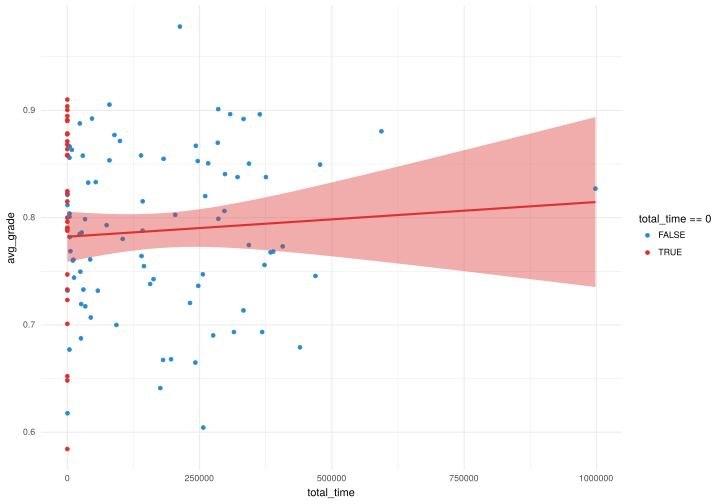

In [420]:
df %>% 
    ggplot(aes(x = total_time, y = avg_grade, group = total_time == 0)) + 
    geom_point(aes(colour = total_time == 0)) +
    geom_smooth(method = "lm")

In [421]:
lm(avg_grade ~ I(total_time / 3600) + I(total_time == 0), data = df) %>% summary()


Call:
lm(formula = avg_grade ~ I(total_time/3600) + I(total_time == 
    0), data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.225701 -0.050217  0.006251  0.065685  0.188995 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.7822439  0.0122292  63.965   <2e-16 ***
I(total_time/3600)     0.0001165  0.0001779   0.655    0.514    
I(total_time == 0)TRUE 0.0278317  0.0192334   1.447    0.151    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07855 on 111 degrees of freedom
Multiple R-squared:  0.01852,	Adjusted R-squared:  0.0008317 
F-statistic: 1.047 on 2 and 111 DF,  p-value: 0.3544
